**Import libraries**

In [1]:
import os
import random
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

**Set seed**

In [2]:
manualSeed = 999

print(f'Random seed = {manualSeed}')
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed = 999


**Set device**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(f'GPU device name: {torch.cuda.get_device_name()}')

GPU device name: Tesla P100-PCIE-16GB


**Unzip dataset**

In [4]:
!unzip -q '/content/drive/MyDrive/pokemon_jpg.zip' -d '/content'

**Initialize hyperparameters**

In [5]:
# root directory for dataset
dataroot = '/content/pokemon_jpg'

# num_workers for DataLoader
workers = 4

# Batch size during training
batch_size = 128

# Image size during training
image_size = 64

# Number of channels (RGB = 3)
nc = 3

# Size of latent vector Z
nz = 100

# Size of feature maps in G (generator)
ngf = 64

# Size of feature maps in D (discriminator)
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate
lr = 0.0002

# Beta1 value for Adam optimizer
beta1 = 0.5

# Number of GPUs
ngpu = 1

**Call dataset and show sample**

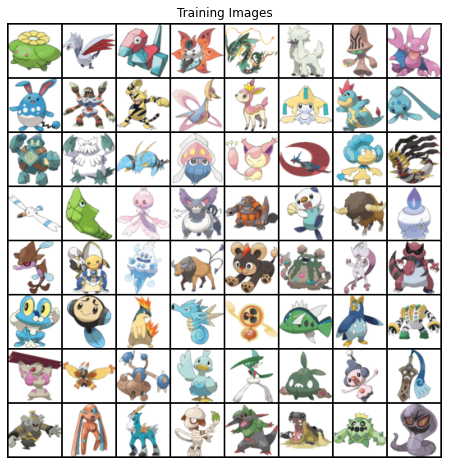

In [6]:
# data augmentation (cropping and normalizing)
pokemon_transforms = transforms.Compose(
    [
     transforms.Resize((image_size, image_size)),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)
    ]
)

# calling and loading the dataset
pokemon_datasets = datasets.ImageFolder(root=dataroot, transform = pokemon_transforms) 
pokemon_dataloader = DataLoader(dataset=pokemon_datasets, batch_size=batch_size,
                                shuffle=True, num_workers=workers, pin_memory=True)

real_batch = next(iter(pokemon_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

**Initialize weights**

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

**Generator class**

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def G_block(in_c, out_c, kernel_size, stride, padding):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, kernel_size,
                                stride, padding, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        
        self.model = nn.Sequential(
            G_block(nz, ngf*16, 4, 1, 0),
            G_block(ngf*16, ngf*8, 4, 2, 1),
            G_block(ngf*8, ngf*4, 4, 2, 1),
            G_block(ngf*4, ngf*2, 4, 2, 1),

            nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

**Generator architecture**

In [9]:
generator = Generator().to(device)
generator.apply(weights_init)

summary(generator, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           6,147
             Tanh-14            [-1, 3,

**Discriminator class**

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def D_block(in_c, out_c, bn=True):
            block = [
                     nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True)
                     ]
            if bn:
                block.insert(1, nn.BatchNorm2d(out_c))
            return block
        
        self.model = nn.Sequential(
            *D_block(3, ndf, bn=False),
            *D_block(ndf, ndf*2),
            *D_block(ndf*2, ndf*4),
            *D_block(ndf*4, ndf*8),

            nn.Conv2d(ndf*8, 1, 4, 2, 0),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

**Discriminator architecture**

In [11]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,193
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,569
Trainable param

**Set loss function, optimizers and noise**

In [12]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

**Training loop**

In [13]:
img_list = []
G_losses = []
D_losses = []
writer_real = SummaryWriter(f'logs/real')
writer_fake = SummaryWriter(f'logs/fake')
step = 0
fixed_noise = torch.randn(32, 100, 1, 1).to(device)

for epoch in range(1, num_epochs+1):
    for batch_idx, (real, _) in enumerate(pokemon_dataloader):
        real = real.to(device)
        noise = torch.randn(batch_size, nz, 1, 1).to(device)
        fake = generator(noise)
        
        # Train D
        D_real = discriminator(real).reshape(-1)
        loss_D_real = criterion(D_real, torch.ones_like(D_real))
        D_fake = discriminator(fake.detach()).reshape(-1)
        loss_D_fake = criterion(D_fake, torch.zeros_like(D_fake))
        loss_D = (loss_D_real + loss_D_fake) / 2
        discriminator.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train G
        output = discriminator(fake).reshape(-1)
        loss_G = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        if batch_idx % 50 == 0:
            print(
                f'Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(pokemon_dataloader)} \
                Loss D: {loss_D:.4f}, Loss G: {loss_G:.4f}'
            )
        
        if (step % 500 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(pokemon_dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
        
        step += 1
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

Epoch [1/1000] Batch 0/7                 Loss D: 0.8806, Loss G: 4.9958
Epoch [2/1000] Batch 0/7                 Loss D: 0.4531, Loss G: 10.0679
Epoch [3/1000] Batch 0/7                 Loss D: 0.3203, Loss G: 9.9020
Epoch [4/1000] Batch 0/7                 Loss D: 0.9923, Loss G: 15.7106
Epoch [5/1000] Batch 0/7                 Loss D: 0.7961, Loss G: 14.6213
Epoch [6/1000] Batch 0/7                 Loss D: 0.3435, Loss G: 3.5310
Epoch [7/1000] Batch 0/7                 Loss D: 1.8854, Loss G: 16.5021
Epoch [8/1000] Batch 0/7                 Loss D: 2.2745, Loss G: 11.5487
Epoch [9/1000] Batch 0/7                 Loss D: 0.5674, Loss G: 7.7968
Epoch [10/1000] Batch 0/7                 Loss D: 1.3200, Loss G: 5.7355
Epoch [11/1000] Batch 0/7                 Loss D: 1.0562, Loss G: 3.3776
Epoch [12/1000] Batch 0/7                 Loss D: 0.5689, Loss G: 3.0946
Epoch [13/1000] Batch 0/7                 Loss D: 0.5275, Loss G: 2.1881
Epoch [14/1000] Batch 0/7                 Loss D: 0.485

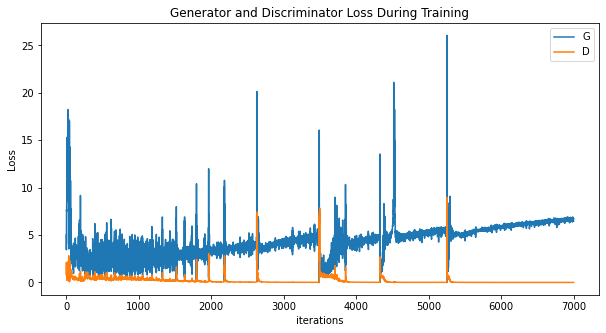

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

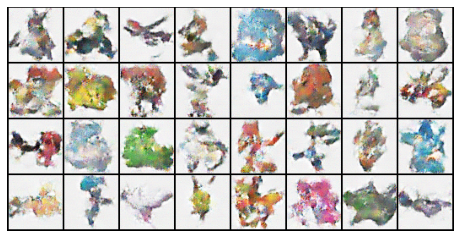

In [22]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat_delay=10, blit=True)

HTML(ani.to_jshtml())

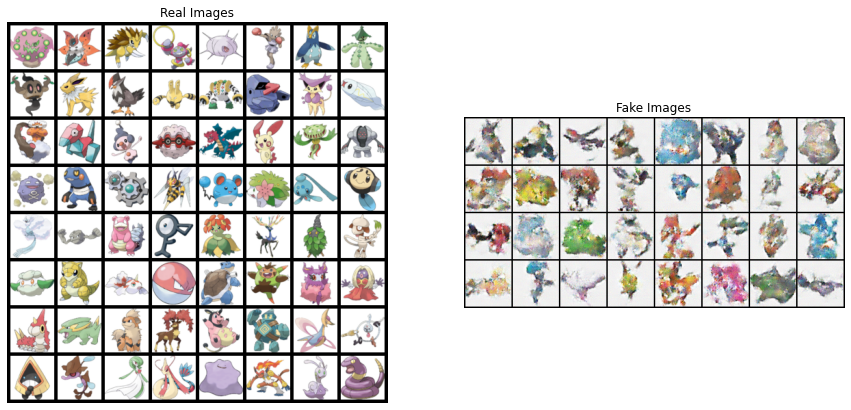

In [16]:
real_batch = next(iter(pokemon_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()